In [3]:
from preamble import *

In [4]:
data = pd.read_csv('./data/j_weather_data_v2.csv')
data = data.drop('snow', axis=1)
data['datetime'] = pd.to_datetime(data['datetime'])
print(type(data), data.shape)
data.head()

<class 'pandas.core.frame.DataFrame'> (15739, 8)


,datetime,temperature,precipitation,wind_speed,humidity,atmospheric_pressure,outflow,input
0,2023-01-01 00:00:00,-0.9,0.0,1.4,72.0,1023.6,4672.98,6063.02
1,2023-01-01 01:00:00,-1.3,0.0,1.5,74.0,1023.3,6425.49,7195.35
2,2023-01-01 02:00:00,-1.7,0.0,1.4,75.0,1023.1,8620.11,7472.46
3,2023-01-01 03:00:00,-2.0,0.0,1.2,77.0,1023.3,8697.04,4809.88
4,2023-01-01 04:00:00,-2.0,0.0,1.7,79.0,1022.8,9543.70,6292.50


In [5]:
data.loc[data['outflow'] <= 1, 'outflow'] = np.nan
median_value = data['outflow'].median()
data['outflow'] = data['outflow'].fillna(median_value)

In [6]:
target_variable = 'outflow'

data_temp = data.copy()
data_temp['outflow_diff'] = data_temp[target_variable].diff().abs()
limit = 0.001 # df_temp['outflow_diff'][2019] = 0.0014899999996487168

flat_regions = []
start_index = None
for i, diff in enumerate(data_temp['outflow_diff']):
  if diff <= limit:
    if start_index is None:
      start_index = i
  elif start_index is not None:
    flat_regions.append((start_index, i - 1))
    start_index = None

# 마지막 구간 처리
if start_index is not None:
  flat_regions.append((start_index, len(df) -1))

threshold = data_temp['outflow_diff'].mean() + 2 * data_temp['outflow_diff'].std()
anomaly_indices = data_temp[data_temp['outflow_diff'] > threshold].index.tolist()

data_dropped = data_temp.drop(index=range(12303, 12515)).reset_index(drop=True)
data_replace = data_dropped.drop('outflow_diff', axis=1)
for index in anomaly_indices:
  if index > 0 and index < len(data_replace) :
    data_replace.loc[index, target_variable] = data_replace.loc[index-1, target_variable]
  elif index == 0 and len(data_replace) > 1:
    data_replace.loc[index, target_variable] = data_replace.loc[index+1, target_variable]
data_cleaned = data_replace.copy()
print(f"Shape of data after replacing outliers : {data_cleaned.shape}")

Shape of data after replacing outliers : (15527, 8)


In [7]:
def create_time_feature(df): 
  df['dayofmonth'] = df['datetime'].dt.day 
  df['dayofweek'] = df['datetime'].dt.dayofweek 
  df['dayofyear'] = df['datetime'].dt.dayofyear 
  df['hour'] = df['datetime'].dt.hour
  df['minute'] = df['datetime'].dt.minute
  df['second'] = df['datetime'].dt.second
  return df

In [8]:
df = create_time_feature(data_cleaned)
df = df.drop('datetime', axis=1)

In [9]:
def create_sequences(data, seq_length, target_length):
  Xs = []
  ys = []
  for i in range(len(data) - seq_length - target_length + 1):
    X = data[i:(i + seq_length)].drop('outflow', axis=1).values
    y = data['outflow'].values[i + seq_length: i+ seq_length + target_length]
    Xs.append(X)
    ys.append(y)
  return np.array(Xs), np.array(ys)

In [10]:
# 파라미터 설정
SEQ_LENGTH = 168  # 과거 7일 (시간 단위)
TARGET_LENGTH = 24 # 이후 24시간 예측

In [11]:
# Sequential Dataset 생성
X, y = create_sequences(df, SEQ_LENGTH, TARGET_LENGTH)

In [12]:
# Train/Test 분할
train_size = int(len(X) * 0.7)
valid_size = int(train_size * 0.1)
print(train_size, valid_size)
X_train, X_test = X[:(train_size - valid_size)], X[train_size:]
y_train, y_test = y[:(train_size - valid_size)], y[train_size:]
X_valid, y_valid = X[(train_size - valid_size):train_size], y[(train_size - valid_size):train_size]

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(X_valid.shape, y_valid.shape)

10735 1073
(9662, 168, 12) (4601, 168, 12) (9662, 24) (4601, 24)
(1073, 168, 12) (1073, 24)


In [13]:
import sklearn
import xgboost

print("scikit-learn version:", sklearn.__version__)
print("XGBoost version:", xgboost.__version__)

scikit-learn version: 1.5.2
XGBoost version: 2.1.3


In [14]:
import xgboost as xgb

# XGBoost 모델 학습
reg = xgb.XGBRegressor(n_estimators=1000, eval_metric="rmse")
reg.fit(
    X_train.reshape(X_train.shape[0], -1), 
    y_train.reshape(-1),
    eval_set=[(X_valid.reshape(X_valid.shape[0], -1), y_valid.reshape(-1))],  # 평가 데이터 설정
    verbose=50  # 50 에포크마다 진행률 출력
)

[0]	validation_0-rmse:2166.28487
[50]	validation_0-rmse:1837.53817
[100]	validation_0-rmse:1866.84491
[150]	validation_0-rmse:1876.56178
[200]	validation_0-rmse:1880.52625
[250]	validation_0-rmse:1881.87141
[300]	validation_0-rmse:1882.21673
[350]	validation_0-rmse:1882.55488
[400]	validation_0-rmse:1882.76630
[450]	validation_0-rmse:1882.87254
[500]	validation_0-rmse:1882.91776
[550]	validation_0-rmse:1882.95595
[600]	validation_0-rmse:1882.98707
[650]	validation_0-rmse:1883.01356
[700]	validation_0-rmse:1883.01502
[750]	validation_0-rmse:1883.01365
[800]	validation_0-rmse:1883.01603
[850]	validation_0-rmse:1883.01642
[900]	validation_0-rmse:1883.01713
[950]	validation_0-rmse:1883.01877
[999]	validation_0-rmse:1883.01857


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [15]:
model_filename = '/model/xgboost_model.json'
reg.save_model(model_filename)

In [16]:
model = xgb.Booster(model_file=model_filename)

In [17]:
# feature importance 시각화
# xgb.plot_importance(reg)
# plt.show()

In [18]:
def predict_future(model, last_window, target_length):
  # 마지막 윈도우를 입력으로 사용하여 예측
  last_window_reshaped = last_window.reshape(1, -1)
  dmatrix_input = xgb.DMatrix(last_window_reshaped)

  predictions = model.predict(dmatrix_input)

  # 예측 결과를 원하는 길이로 자르기
  return predictions.reshape(target_length)

In [19]:
from sklearn.metrics import mean_squared_error, r2_score

# Test 데이터 예측
y_pred = np.array([predict_future(model, X_test[i], TARGET_LENGTH) for i in range(len(X_test))])

# 예측 결과 평가
mse = mean_squared_error(y_test.reshape(-1), y_pred.reshape(-1))
rmse = np.sqrt(mse)
r2 = r2_score(y_test.reshape(-1), y_pred.reshape(-1))
print(f'MSE : {mse}, RMSE : {rmse} R-value : {r2}')

MSE : 4939845.5064561535, RMSE : 2222.5763218517723 R-value : 0.23368439268609542


In [20]:
data['datetime'][train_size:train_size + 24]

10735   2024-03-23 07:00:00
10736   2024-03-23 08:00:00
10737   2024-03-23 09:00:00
10738   2024-03-23 10:00:00
10739   2024-03-23 11:00:00
10740   2024-03-23 12:00:00
10741   2024-03-23 13:00:00
10742   2024-03-23 14:00:00
10743   2024-03-23 15:00:00
10744   2024-03-23 16:00:00
10745   2024-03-23 17:00:00
10746   2024-03-23 18:00:00
10747   2024-03-23 19:00:00
10748   2024-03-23 20:00:00
10749   2024-03-23 21:00:00
10750   2024-03-23 22:00:00
10751   2024-03-23 23:00:00
10752   2024-03-24 00:00:00
10753   2024-03-24 01:00:00
10754   2024-03-24 02:00:00
10755   2024-03-24 03:00:00
10756   2024-03-24 04:00:00
10757   2024-03-24 05:00:00
10758   2024-03-24 06:00:00
Name: datetime, dtype: datetime64[ns]

In [21]:
y_test.shape

(4601, 24)

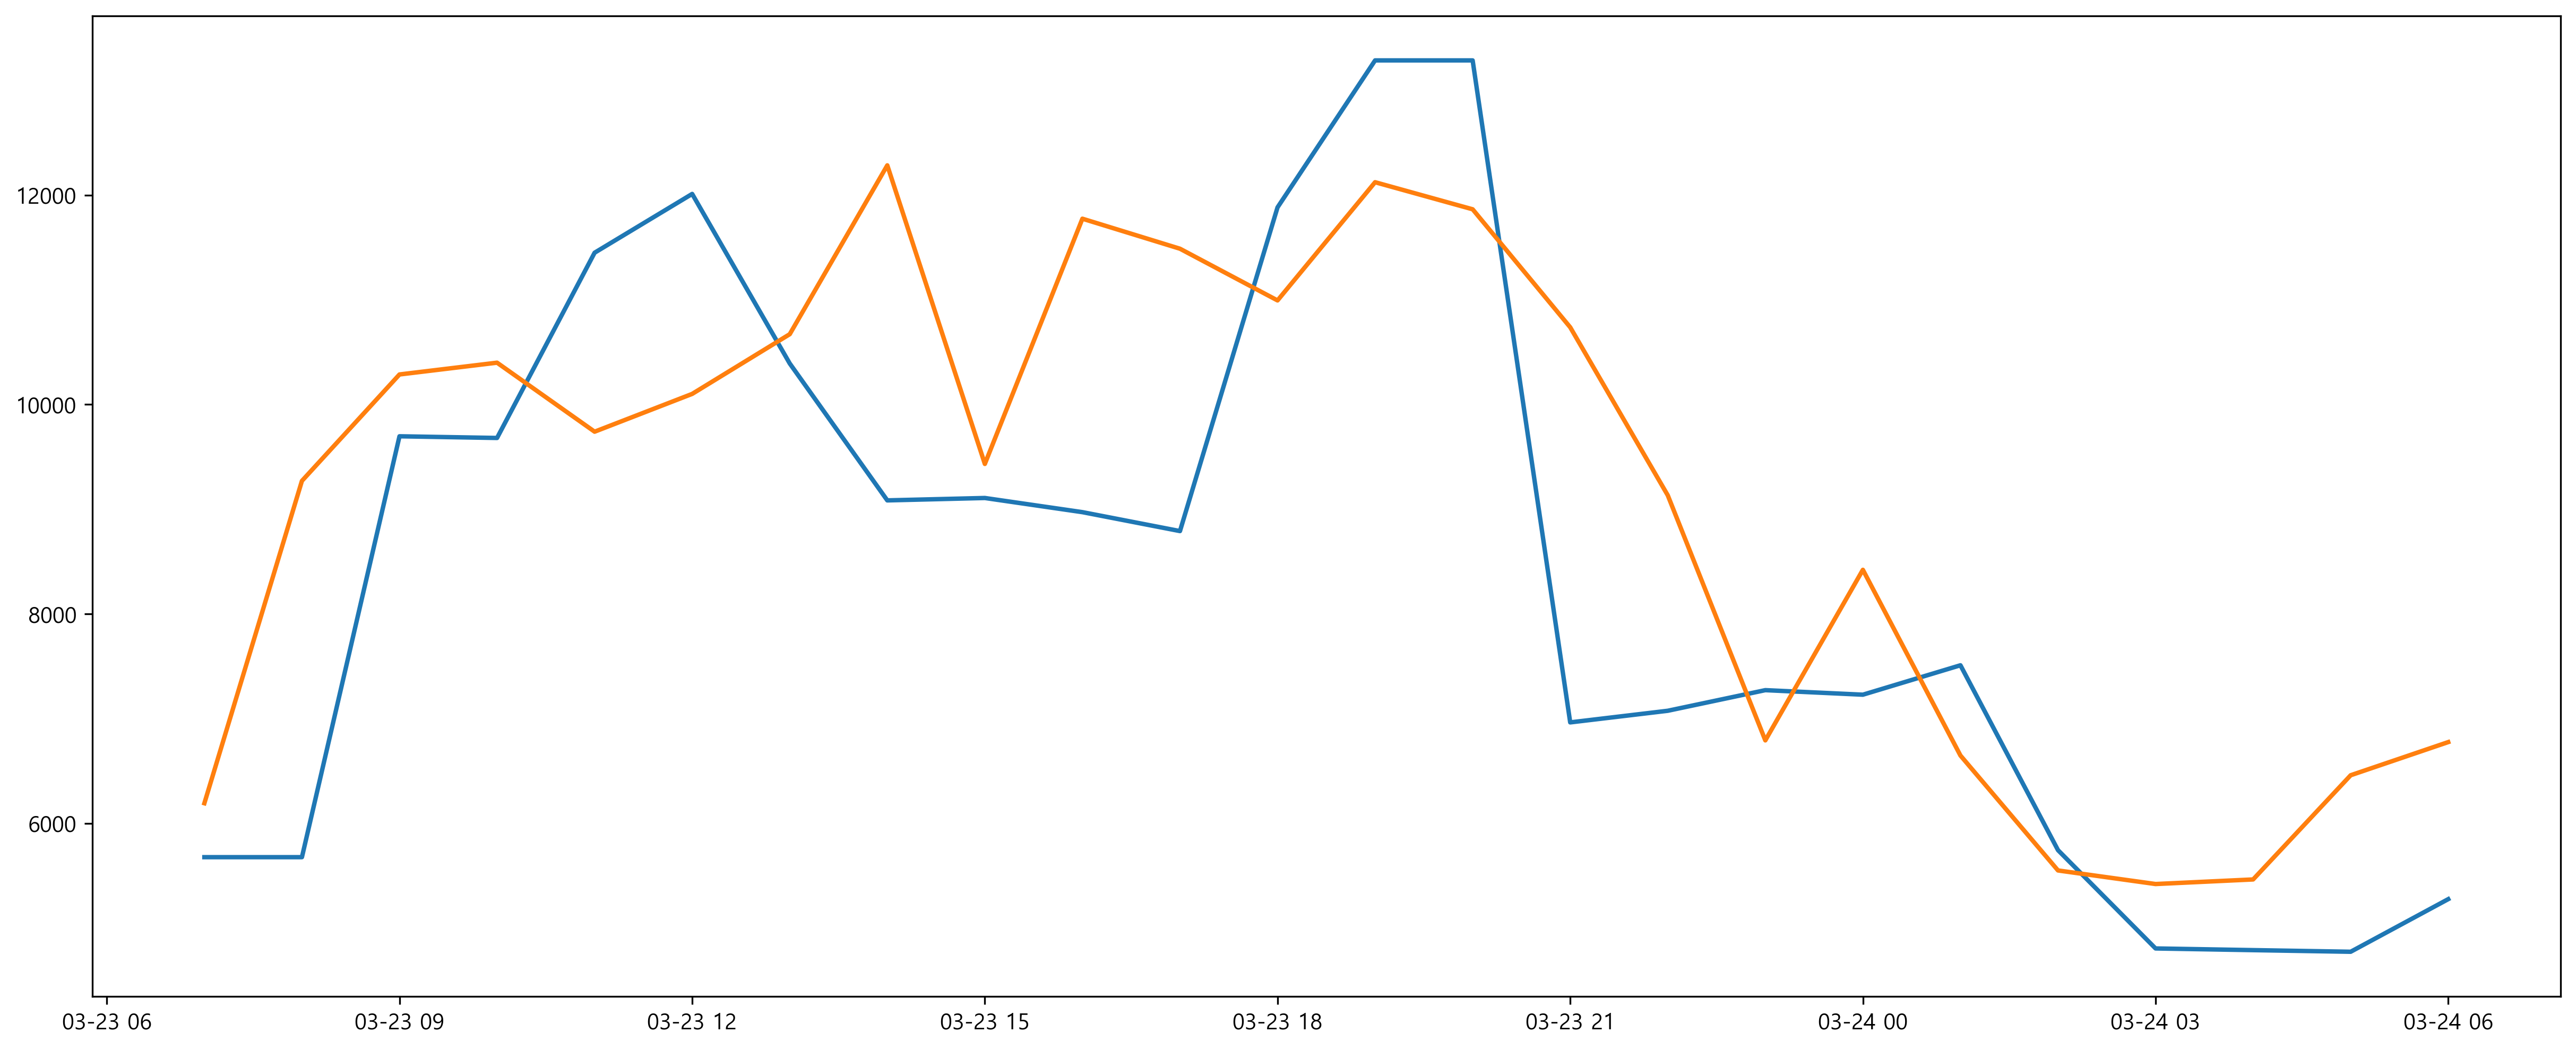

In [22]:
plt.figure(figsize=(20, 8))
plt.plot(data['datetime'][train_size:train_size + 24], y_test[0])
plt.plot(data['datetime'][train_size:train_size + 24], y_pred[0])
plt.show()

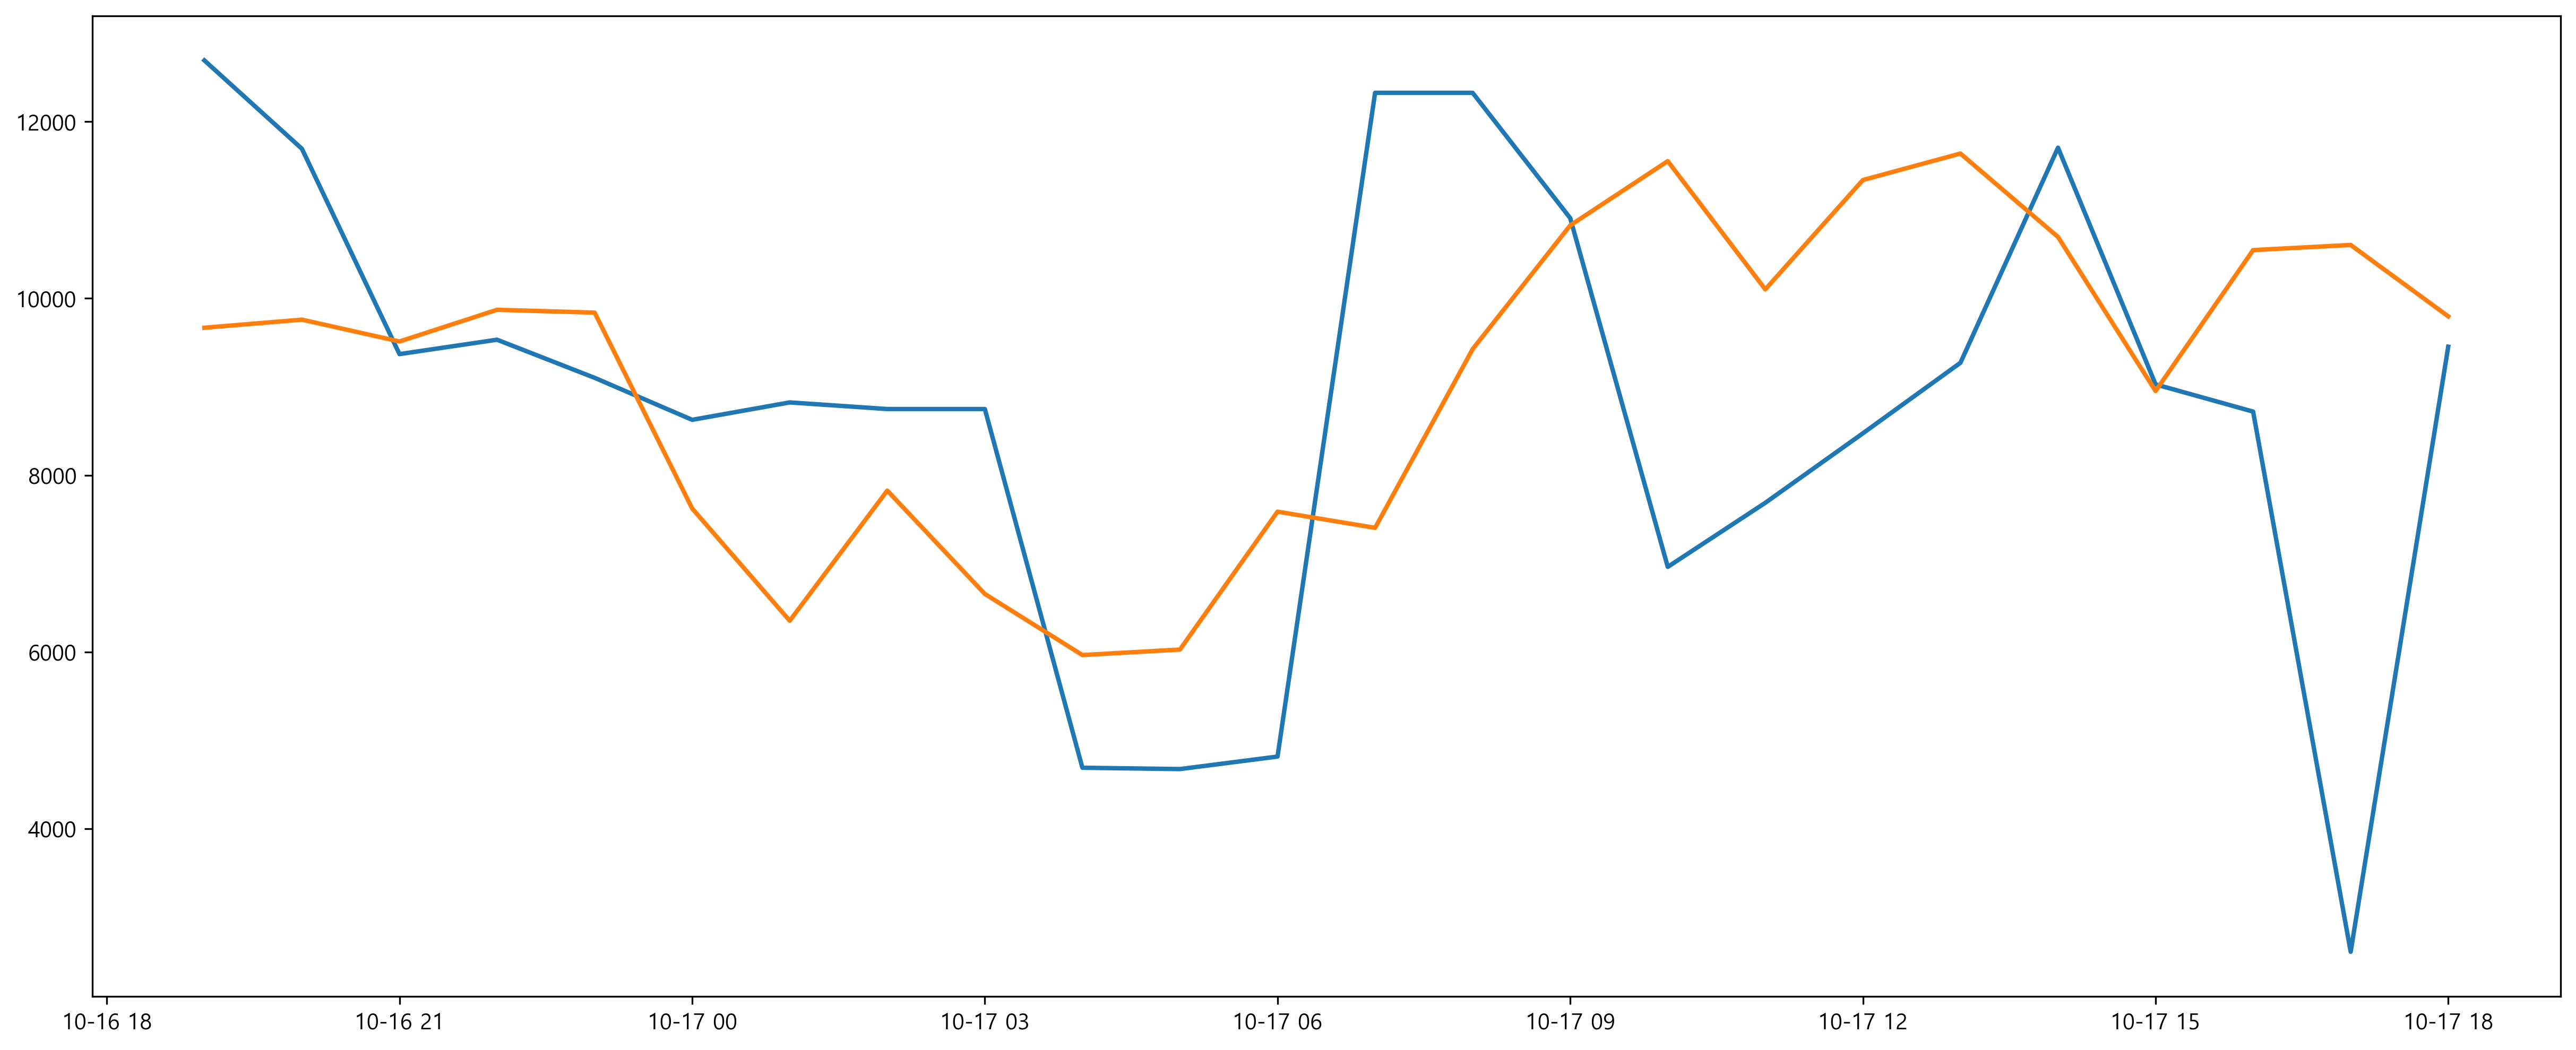

In [23]:
plt.figure(figsize=(20, 8))
plt.plot(data['datetime'][-24:], y_test[-1])
plt.plot(data['datetime'][-24:], y_pred[-1])
plt.show()